# 1. Setup and Upload Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/raw_data.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib




# 3: Data Cleaning & Preprocessing

In [ ]:
# Convert date columns
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values (basic approach)
df.fillna({
    'order_delivered_customer_date': df['order_estimated_delivery_date'],
    'order_delivered_carrier_date': df['order_purchase_timestamp']
}, inplace=True)

# Create additional date features
df['day_of_purchase'] = df['order_purchase_timestamp'].dt.day
df['month_of_purchase'] = df['order_purchase_timestamp'].dt.month
df['year_of_purchase'] = df['order_purchase_timestamp'].dt.year
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M')

# Calculate shipping duration
df['shipping_duration'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

print("\n=== Dataset Info ===")
print(df.info())
print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113390 entries, 0 to 113389
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Unnamed: 0                     113390 non-null  int64         
 1   order_id                       113390 non-null  object        
 2   order_item_id                  113390 non-null  int64         
 3   customer_id                    113390 non-null  object        
 4   customer_unique_id             113390 non-null  object        
 5   customer_zip_code_prefix       113390 non-null  int64         
 6   customer_city                  113390 non-null  object        
 7   customer_state                 113390 non-null  object        
 8   product_id                     113390 non-null  object        
 9   product_category_name          113390 non-null  object        
 10  product_name_lenght            113390 non-null

# 4. Exploratory Data Analysis & Visualization

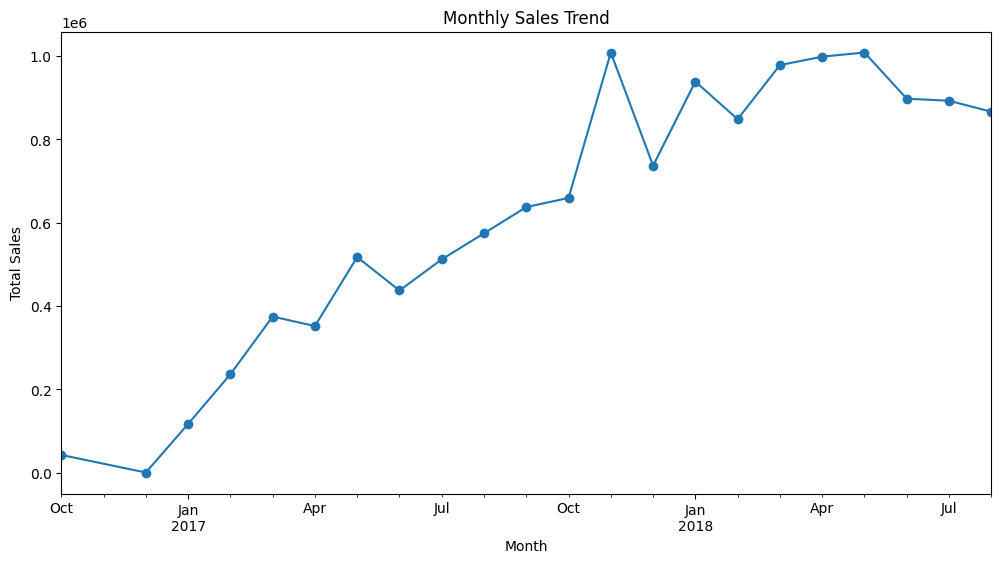

In [ ]:
# 1. Monthly sales trend
monthly_sales = df.groupby('month_year')['price'].sum()
monthly_sales.plot(kind='line', marker='o', title='Monthly Sales Trend', figsize=(12,6))
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

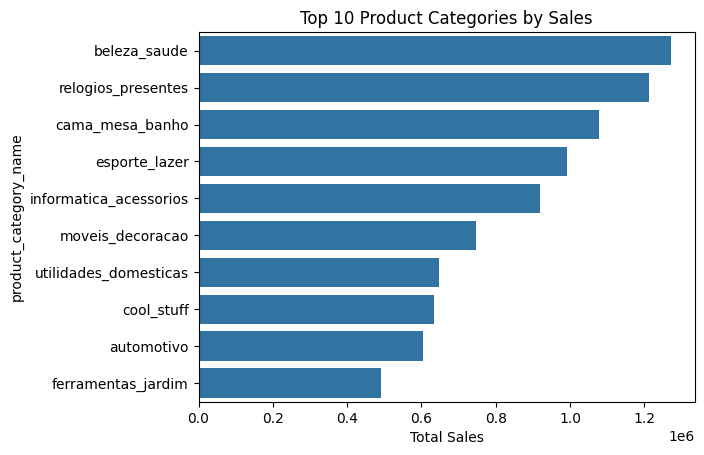

In [ ]:
# 2. Top 10 product categories
top_categories = df.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Product Categories by Sales")
plt.xlabel("Total Sales")
plt.show()


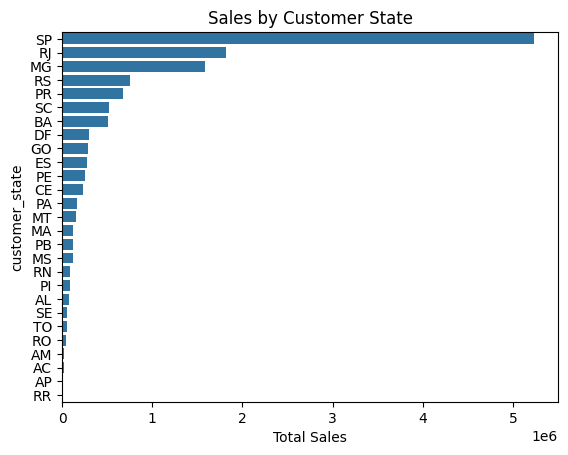

In [ ]:
# 3. Sales by State
sales_by_state = df.groupby('customer_state')['price'].sum().sort_values(ascending=False)
sns.barplot(x=sales_by_state.values, y=sales_by_state.index)
plt.title("Sales by Customer State")
plt.xlabel("Total Sales")
plt.show()

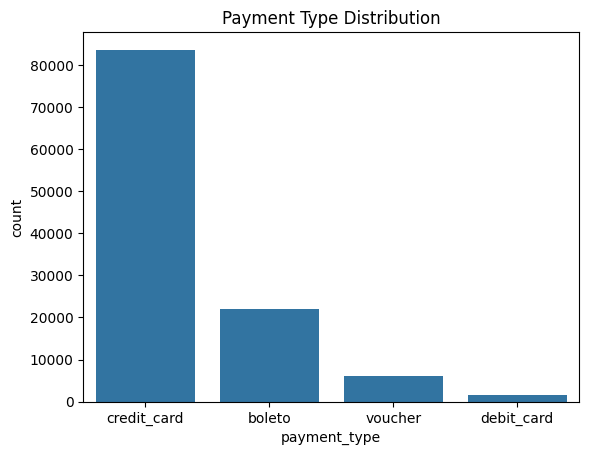

In [ ]:
# 4. Payment Type Distribution
sns.countplot(x='payment_type', data=df)
plt.title("Payment Type Distribution")
plt.show()

# 5: Feature Engineering for Forecasting

In [ ]:
# Aggregate daily sales for forecasting
daily_sales = df.groupby(df['order_purchase_timestamp'].dt.date)['price'].sum().reset_index()
daily_sales.rename(columns={'order_purchase_timestamp':'date', 'price':'sales'}, inplace=True)

# Create time features
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['day_of_week'] = daily_sales['date'].dt.weekday

print("Daily Sales Data:")
print(daily_sales.head())


Daily Sales Data:
        date    sales  day  month  year  day_of_week
0 2016-10-03   463.48    3     10  2016            0
1 2016-10-04  9093.20    4     10  2016            1
2 2016-10-05  6349.47    5     10  2016            2
3 2016-10-06  5889.96    6     10  2016            3
4 2016-10-07  6705.23    7     10  2016            4


# 6:Train/Test Split and Modeling

In [ ]:
X = daily_sales[['day', 'month', 'year', 'day_of_week']]
y = daily_sales['sales']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Model Evaluation ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")



=== Model Evaluation ===
RMSE: 10893.13
MAE: 8173.74
R² Score: 0.04


# 7: Visualization of Predictions

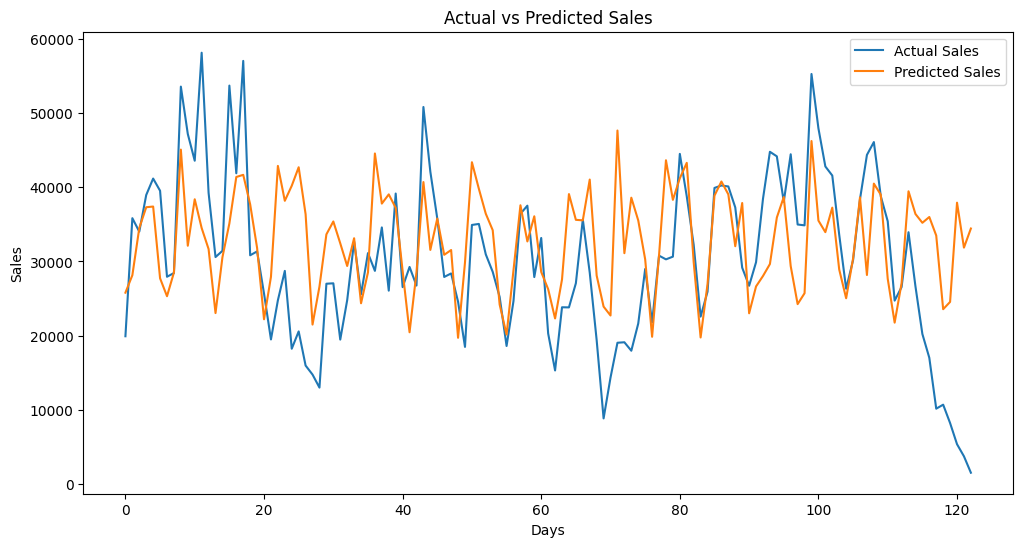

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Save Model and Results

In [ ]:
# Save model
joblib.dump(model, 'xgboost_sales_model.pkl')

# Save predictions for Power BI
results = X_test.copy()
results['actual_sales'] = y_test.values
results['predicted_sales'] = y_pred
results['date'] = daily_sales['date'].iloc[-len(y_test):].values
results.to_csv('forecast_results.csv', index=False)

print("\n✅ Project Completed! Model and results saved.")


✅ Project Completed! Model and results saved.


In [ ]:
# Export processed datasets for Power BI
df.to_csv('raw_data_for_dashboard.csv', index=False)
daily_sales.to_csv('processed_daily_sales.csv', index=False)
results.to_csv('forecast_results.csv', index=False)

# Download them
from google.colab import files
files.download('raw_data_for_dashboard.csv')
files.download('processed_daily_sales.csv')
files.download('forecast_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.to_csv('raw_data_for_dashboard.csv', index=False)
files.download('raw_data_for_dashboard.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>